In [12]:
# Settings
#filename    = '/home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5'
filename     = '/home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2015_10_28/background_trigger_logic_600th_151028.hdf5'
#filename    = '/home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2015_10_02/Kr_Measurement_1000TH_1_151002.hdf5'
#filename    = '/media/axel/cf2b7088-fe0f-419a-a101-07493d88971c/kabelchange.hdf5.hdf5'
file_format = 'hdf5'
#loglevel    = 'DEBUG'

In [13]:
import logging
log = logging.getLogger('Gaseous basic statistics')
log.setLevel('DEBUG')

import numpy as np

import matplotlib   # Needed for font size spec, color map transformation function bla bla
%matplotlib inline
matplotlib.rc('font', size=16)
import matplotlib.pyplot as plt

# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    log.debug("You don't have tqdm, I can't give you a nice progress bar...")
    def dummy(*args,**kwargs):
        return args[0]
    tqdm = dummy

from recarray_tools import append_fields, fields_view, group_by, filter_on_fields, fields_data

peak_types = [b's1', b's2', b'unknown', b'noise', b'lone_hit']

In [14]:
##
# Load the data
##

log.debug("Now loading %s (file format=%s)..." % (filename, file_format))

# Slurp peaks and events into memory
# WARNING: For a large dataset, use pax to remove big low-level fields first
# (area_per_channel, does_channel_contribute, does_channel_have_noise)
try:
    # Load the file using pax 3's IO code
    from pax.formats import flat_data_formats
    ioformat = flat_data_formats[file_format]()
    ioformat.open(filename, 'r')
    events = ioformat.read_data('Event')
    try:
        peaks = ioformat.read_data('Peak')
    except KeyError:
        peaks = None
        log.info("There is no peak table")
    hits = ioformat.read_data('Hit')
    ioformat.close()
except ImportError:
    log.debug("You don't have pax 3 installed, falling back to HDF5-specific code...")
    import h5py
    f = h5py.File(filename)
    events = f.get('Event')[:]
    peaks = f.get('Peak')[:]
    hits = f.get('Hit')[:]
    f.close()
if peaks != None:
    log.info("Loaded %s, containing %d peaks (%0.2f MB RAM) and %d events (%0.2f MB RAM)" % (
    filename, len(peaks), peaks.nbytes/10**6, len(events), events.nbytes/10**6))
if len(events) == 0:
    raise ValueError("You don't have any events in this dataset!")

DEBUG:Gaseous basic statistics:Now loading /home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2015_10_28/background_trigger_logic_600th_151028.hdf5 (file format=hdf5)...
DEBUG:Gaseous basic statistics:You don't have pax 3 installed, falling back to HDF5-specific code...
/home/axel/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
INFO:Gaseous basic statistics:Loaded /home/axel/ownCloud/documents/Masterarbeit/TPC/rawdata/2015_10_28/background_trigger_logic_600th_151028.hdf5, containing 302046 peaks (755.12 MB RAM) and 114421 events (43.94 MB RAM)


In [15]:
# Adding extra fields


(array([ 35453,  59713,  30898, 118353,  19154,  13446,  32324,  35819,
        26949,    421,  21743,  51097,  30663,  20253]), array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.]))


/home/axel/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


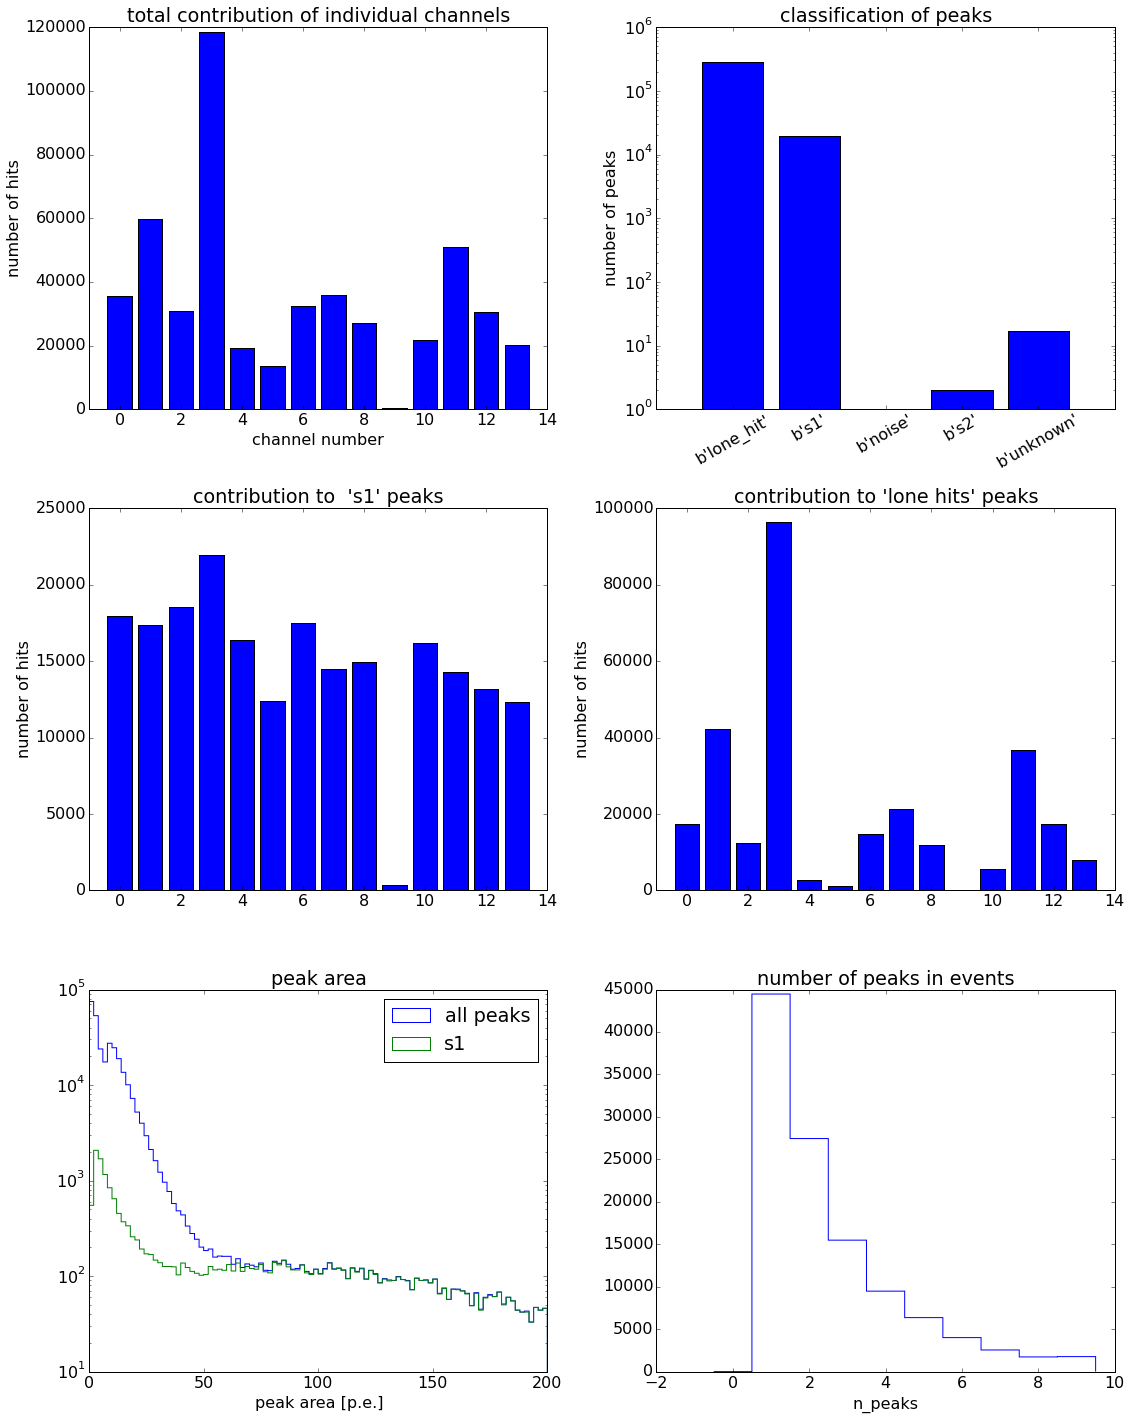

In [16]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,20), squeeze=False)
area_right_boundary = 200
area_bins = 100

if True:
    
    ### making histogram of hits
    z = np.histogram(hits["channel"], bins=14, range=(0,14))
    print(z)
    plt.cla()
    ax1.bar(range(14),z[0], align="center")
    ax1.set_xlabel("channel number")
    ax1.set_ylabel("number of hits")
    ax1.set_title("total contribution of individual channels")
    ax1.set_xlim((-1,14))
    
    ### now checking how peaks were identified
    peak_type_sums = dict()
    for peaktype in peak_types:
        z = (peaks["type"] == peaktype)
        peak_type_sums[peaktype] = sum(z)
    ax2.bar(range(len(peak_types)), peak_type_sums.values(),align="center")
    ax2.set_ylabel("number of peaks")
    xlabels = [""]
    xlabels.extend(list(peak_type_sums.keys()))
    ax2.set_xticklabels(labels= xlabels, rotation = 30)
    ax2.set_title("classification of peaks")
    ax2.set_yscale("log")
    #ax2.set_xlim((-1,14))
    
    ### 
    import pandas as pd
    # making a histogram of contributing channels towards peaks
    # looking at coincidential peaks (type != lone_hit) 
    s1_peaks = peaks["type"] == b"s1"
    lone_hits = peaks["type"] == b"lone_hit"

    a = pd.DataFrame(peaks[s1_peaks]["hits_per_channel"])
    b = pd.DataFrame(peaks[lone_hits]["hits_per_channel"])
    ax3.bar(list(a), list(a.sum()),align="center")
    ax3.set_title("contribution to  's1' peaks")
    
    ax4.set_title("contribution to 'lone hits' peaks")
    ax4.bar(list(b), list(b.sum()),align="center")
    
    ax3.set_xlim((-1,14))
    ax3.set_ylabel("number of hits")
    ax4.set_xlim((-1,14))
    ax4.set_ylabel("number of hits")
    
    ax5.set_title("peak area")
    ax5.hist(peaks["area"], bins=area_bins, histtype="step", range=(0,area_right_boundary), label="all peaks")
    ax5.hist(peaks[s1_peaks]["area"], bins=area_bins, histtype="step", range=(0,area_right_boundary), label = "s1")
    ax5.set_xlabel("peak area [p.e.]")
    #ax5.set_ylabel("#")
    ax5.set_xlim((0,area_right_boundary))
    ax5.legend(loc="best")
    ax5.set_yscale("log")
    
    ax6.set_title("number of peaks in events")
    ax6.hist(events["n_peaks"], bins=10, histtype="step", range=(0,10), align="left")
    ax6.set_xlabel("n_peaks")
    
    fig.tight_layout()
    fig.show()

/home/axel/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


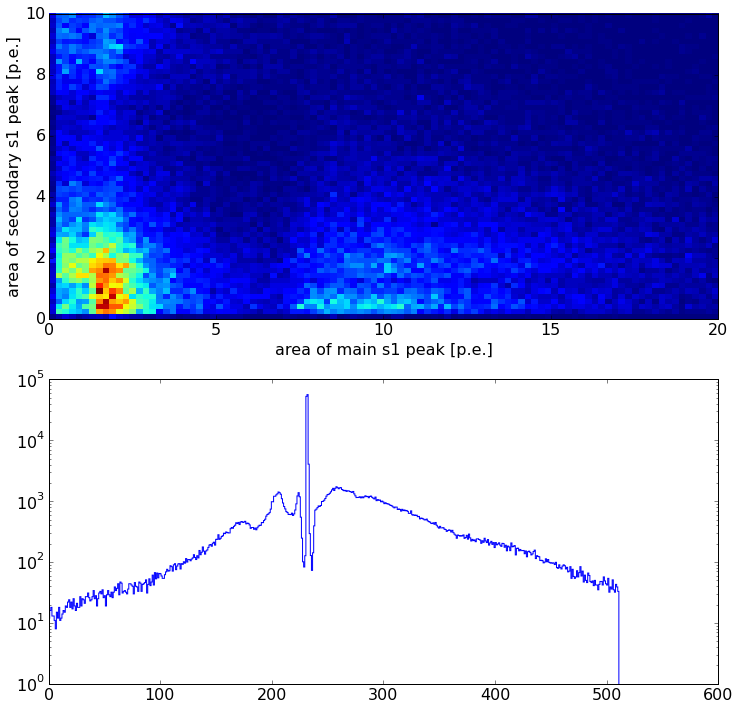

In [17]:
### Now finding events that contain >=2 peaks
### Then plotting energy of first peak (ordered by area) vs the second peak

multi_peak_events = events[events["n_peaks"]>= 2]

peak_by_event = group_by(peaks, "Event")

main_peaks = []
secondary_peaks = []

for event_peaks in peak_by_event:
    #print(event_peaks["area"])
    event_peaks = sorted(event_peaks, key= lambda x : x["index_of_maximum"],reverse=True)
    #print(event_peaks[0]["area"])
    if len(event_peaks)<= 1:
        continue
    if event_peaks[0]["type"] == b"s1":
        continue
    if event_peaks[1]["type"] == b"s1":
        continue
    main_peaks.append(event_peaks[0])
    secondary_peaks.append(event_peaks[1])
    

main_areas = [peak["area"] for peak in main_peaks]
secondary_areas =[peak["area"] for peak in secondary_peaks]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
ax1.hist2d(main_areas, secondary_areas, bins=[100,60], range=((0,20),(0,10)))
ax1.set_xlabel("area of main s1 peak [p.e.]")
ax1.set_ylabel("area of secondary s1 peak [p.e.]")
#ax.set_xlim(0,150)
#ax.set_ylim(0,50)

ax2.hist(peaks["index_of_maximum"], bins=512, histtype="step")
ax2.set_yscale("log")
fig.show()


    
#ax.hist2d?

[('Event', '<i8'), ('Peak', '<i8'), ('Hit', '<i8'), ('area', '<f4'), ('center', '<f4'), ('channel', '<i8'), ('found_in_pulse', '<i8'), ('height', '<f4'), ('index_of_maximum', '<i8'), ('is_rejected', '<i8'), ('left', '<i8'), ('n_saturated', '<i8'), ('noise_sigma', '<f4'), ('right', '<i8'), ('sum_absolute_deviation', '<f4')]


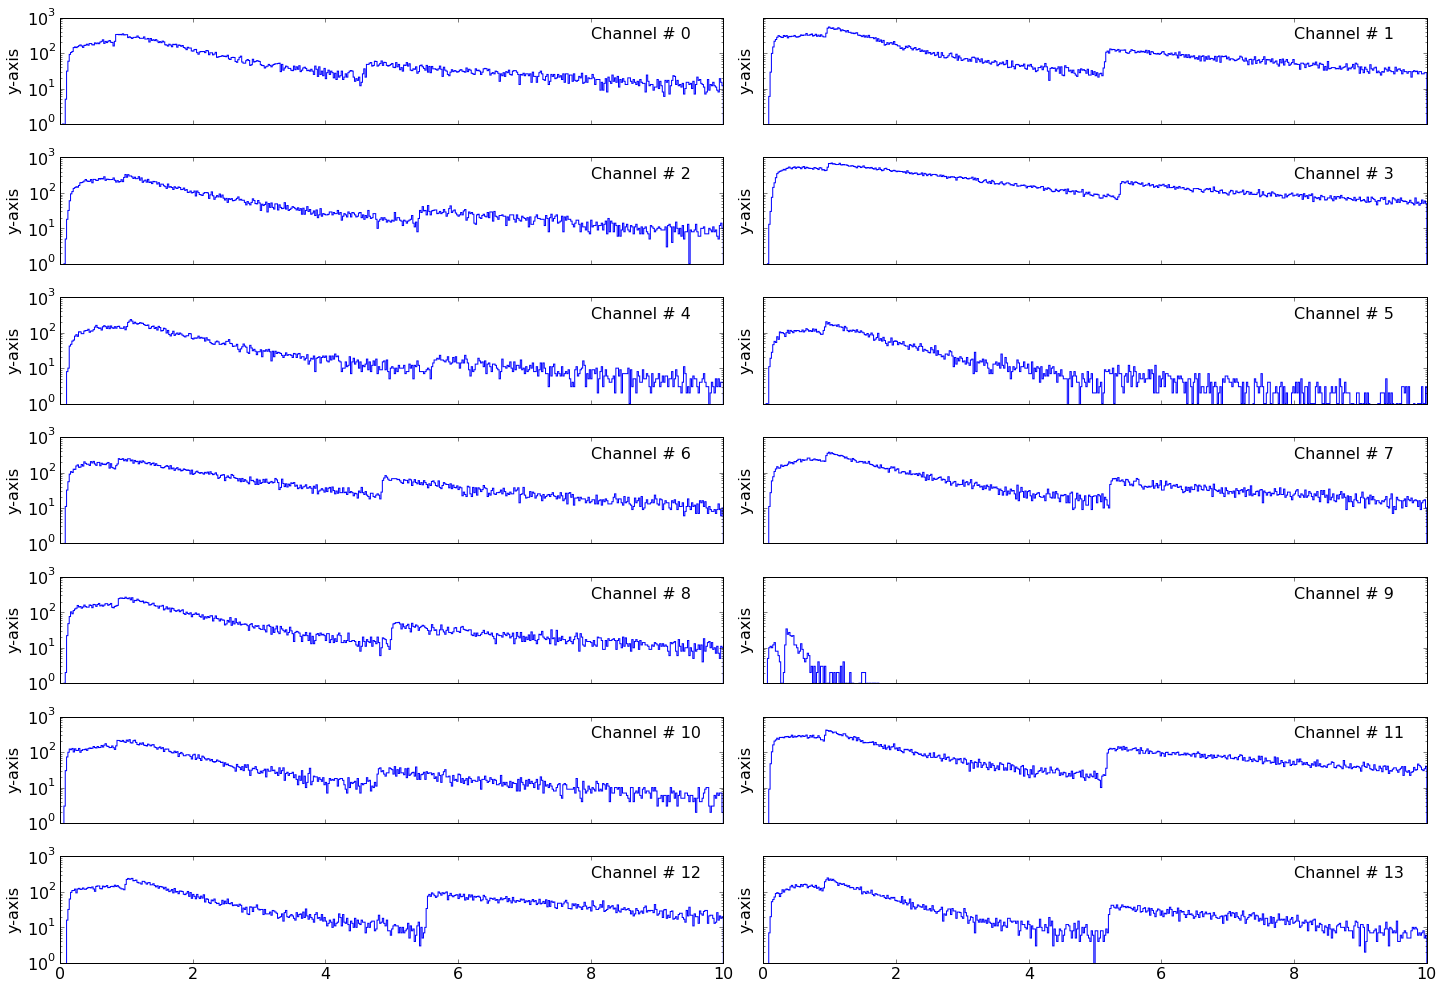

In [18]:
import plot_by_channel
print(hits.dtype)
plot_by_channel.make_plot(hits, "height",range=(0,10), xlim=(0,10))